Let's go for RNN based on https://github.com/AbhishekAnand18/ImageTextRecognition/blob/master/ImageTextRecognition_Code.ipynb

In [1]:
!pip install Pillow
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import clear_output
import time
import os
from skimage.filters import threshold_local
import keras
import random
from keras import backend as K
#from skimage.morphology import skeletonize
import itertools
import datetime


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
import tensorflow as tf

# List available devices
devices = tf.config.list_physical_devices()

for device in devices:
    print(device)


PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [16]:
dir_path = '/kaggle/input/orand-car-dataset/ORAND-CAR-2014/'
CAR_A_test_images_path = dir_path + 'CAR-A/a_test_images/'
CAR_A_train_images_path = dir_path + 'CAR-A/a_train_images/'
CAR_B_test_images_path = dir_path + 'CAR-B/b_test_images/'
CAR_B_train_images_path = dir_path + 'CAR-B/b_train_images/'

def load_original_images():
    images_path = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.png'):
                image_path = os.path.join(root, file)
                images_path.append(image_path.replace('\\','/'))
    return images_path

images_path = load_original_images()

def calculate_digit_count(label):
    return len(label)

def get_labels(image_dir,text_path):
  with open(text_path,'r') as f :
    lines = f.readlines()
  listt = []
  for line in lines :
    parts = line.strip().split("\t")
    listt.append([image_dir + parts[0],parts[1]])
  DF = pd.DataFrame(listt)
  DF = DF.rename(columns={0: 'image_path', 1: 'label'})
  return DF

def get_all_labels():
  CAR_A_test_text = dir_path + 'CAR-A/a_test_gt.txt'
  CAR_A_train_text = dir_path + 'CAR-A/a_train_gt.txt'
  CAR_B_test_text = dir_path + 'CAR-B/b_test_gt.txt'
  CAR_B_train_text = dir_path + 'CAR-B/b_train_gt.txt'
  a_test_label_df = get_labels(CAR_A_test_images_path,CAR_A_test_text)
  a_train_label_df = get_labels(CAR_A_train_images_path,CAR_A_train_text)
  b_test_label_df = get_labels(CAR_B_test_images_path,CAR_B_test_text)
  b_train_label_df = get_labels(CAR_B_train_images_path,CAR_B_train_text)
  all_labels = pd.concat([a_test_label_df , a_train_label_df , b_test_label_df , b_train_label_df],ignore_index=True)#.reset_index()
  return all_labels

def reset_data():
  all_labels = get_all_labels()
  print(len(all_labels))
  print(len(all_labels['image_path'].unique())) # no dupicate image name
  # all_labels["actual_digit_count"] = all_labels["label"].astype(str).apply(calculate_digit_count)
  return all_labels

all_labels = reset_data()

11719
11719


In [17]:
all_labels

,image_path,label
0,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1500
1,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,5743
2,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1056
3,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1000
4,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1000
...,...,...
11714,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,100000
11715,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,85000
11716,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,150000
11717,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,13356


## Functionanl methods

In [18]:
def get_size_dataFrame(all_labels,column):
    height_list = []
    width_list = []
    for image_path in all_labels[column]:
        height = Image.open(image_path).height
        width = Image.open(image_path).width

        height_list.append(height)
        width_list.append(width)

    sizes_df = pd.DataFrame({'width':width_list,'height':height_list})
    return sizes_df


def plot_random_image(image_label_df,from_path):
    random.seed(42)
    indices = list(range(len(image_label_df)))
    random.shuffle(indices)

    for idx in indices[:10]+[21,22]:
        target_image = image_label_df[from_path][idx]
        print("label:", image_label_df['label'][idx])
        print("target:", target_image)
        image = mpimg.imread(target_image)
        plt.imshow(image)
        plt.show()
        time.sleep(2)
        clear_output(wait=True)


def convert_to_grayscale(df, from_path,new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, gray_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df


def denoise_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        denoised_image = cv2.GaussianBlur(gray_img, (5, 5), 0)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_image)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df


def denoise_images_fastnlmeans(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df


def resize_images_with_height(df,from_path, new_dir_path, target_height):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape
        target_width = int(width * (target_height / height))
        resized_img = cv2.resize(img, (target_width, target_height))
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, resized_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


def resize_images(df,from_path, new_dir_path, target_height,target_width):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (target_width, target_height))
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, resized_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

def invert_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        bin_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        inverted_img = cv2.bitwise_not(bin_img)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, inverted_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

def binarize_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        im = Image.open(img_path)
        im = np.array(im)
        _, binary_im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_im = Image.fromarray(binary_im)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        binary_im.save(save_path)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

def denoise_images_fastnlmeans(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_img)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


def denoise_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        denoised_image = cv2.GaussianBlur(gray_img, (5, 5), 0)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_image)

    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

## Creating new images

In [19]:
import cv2
import pandas as pd
import numpy as np
from skimage import io, transform, util
from skimage.transform import rotate
from skimage.util import random_noise

os.makedirs('/kaggle/working/created/')

augmentation_params = {
    'resize_range': (0.65, 1.5),
    'flip_prob': 0.1,
    'noise_var': 0.01,
    'rotate_angle_range': (-10, 10)
}

new_data = {
    'image_path': [],
    'label': []
}

for i in range(4):
  for index, row in all_labels.iterrows():
      label = row['label']
      # Check if the label contains any digit except 0
      if '0' not in label:
          image_path = row['image_path']

          # Read the image
          img = io.imread(image_path, as_gray=True)

          # Resize by random ratio
          ratio = np.random.uniform(*augmentation_params['resize_range'])
          resized_img = transform.rescale(img, scale=ratio, mode='constant')

          # Horizontal flip with a certain probability
          if np.random.rand() < augmentation_params['flip_prob']:
              resized_img = np.fliplr(resized_img)

          # Rotate by a random angle
          angle = np.random.uniform(*augmentation_params['rotate_angle_range'])
          rotated_img = rotate(resized_img, angle, mode='edge')

          # Add Gaussian noise
          noisy_img = random_noise(rotated_img, var=augmentation_params['noise_var'])

          new_data['image_path'].append(noisy_img)
          new_data['label'].append(label)

new_df = pd.DataFrame(new_data)


In [24]:
new_df

,image_path,label
0,"[[0.6169432575672931, 0.6819341569870041, 0.61...",5743
1,"[[0.6319797741101508, 0.6363574287432385, 0.72...",8548
2,"[[0.6255109311106856, 0.6817275307501326, 0.68...",38117
3,"[[0.5947979608770582, 0.8402902973597111, 0.81...",676
4,"[[0.47809283235164063, 0.3464241787097989, 0.6...",219
...,...,...
15787,"[[0.9163071580688726, 0.7453556069181249, 0.81...",45954
15788,"[[0.641632368223344, 0.7386203089618358, 0.838...",444665
15789,"[[0.7246696920491676, 0.43975820714708996, 0.4...",29524
15790,"[[0.7645575727111724, 0.5707815595210076, 0.69...",6792972


In [27]:
last_image = len(all_labels)
new_im_paths = [os.path.join('/kaggle/working/created/', f"{i:05d}.png") for i in range(last_image, last_image + len(new_df))]
new_im_labels = new_df['label']
for img_array, new_im_path in zip(new_df['image_path'], new_im_paths):

    img_array = (img_array * 255).astype(np.uint8)

    # Ensure image array has the correct shape (height x width)
    if len(img_array.shape) == 3:
        img_array = img_array[:, :, 0]  # Extract the first channel (grayscale)

    # Save the grayscale image
    cv2.imwrite(new_im_path, img_array)
new_path_df = pd.DataFrame({'image_path': new_im_paths, 'label': new_im_labels})
all_labels = pd.concat([all_labels, new_path_df], ignore_index=True)



In [31]:
all_labels

,image_path,label
0,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1500
1,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,5743
2,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1056
3,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1000
4,/kaggle/input/orand-car-dataset/ORAND-CAR-2014...,1000
...,...,...
27506,/kaggle/working/created/27506.png,45954
27507,/kaggle/working/created/27507.png,444665
27508,/kaggle/working/created/27508.png,29524
27509,/kaggle/working/created/27509.png,6792972


## Preproccesing

In [32]:
# Gray scale
all_labels = convert_to_grayscale(all_labels,'image_path','/kaggle/working/grayscaled/')

In [33]:
sizes_df = get_size_dataFrame(all_labels,'/kaggle/working/grayscaled/')
sizes_df.describe()

,width,height
count,27511.000000,27511.000000
mean,174.931155,57.200720
std,56.416293,14.128367
min,29.000000,23.000000
25%,136.000000,47.000000
50%,169.000000,55.000000
75%,208.000000,65.000000
max,510.000000,134.000000


In [ ]:
heights = sizes_df['height'].value_counts()
value_counts_df = heights.reset_index()
value_counts_df.columns = ['Value', 'Count']
plt.bar(heights.index, heights.values)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values')
plt.show()


In [ ]:
widths = sizes_df['width'].value_counts()
value_counts_df = widths.reset_index()
value_counts_df.columns = ['Value', 'Count']
plt.bar(widths.index, widths.values)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values')
plt.show()


In [34]:
# resize to specific height
# target_height = 28
# all_labels = resize_images_with_height(all_labels,'./grayscaled/', './resized/', target_height)
all_labels = resize_images(all_labels,'/kaggle/working/grayscaled/', '/kaggle/working/resized/', target_height=54,target_width=174)


In [35]:
# Denoising
# all_labels = denoise_images(all_labels, './resized/', './denoised/')
all_labels = denoise_images_fastnlmeans(all_labels, '/kaggle/working/resized/', '/kaggle/working/denoised_fastnlmeans/')

# binarizing and inverting
# block_size = 9
# offset = 0
# all_labels = local_threshold_images(all_labels, './edges/', './local_thresholded/', block_size, offset)
all_labels = binarize_images(all_labels, '/kaggle/working/denoised_fastnlmeans/', '/kaggle/working/binarized/')
all_labels = invert_images(all_labels, '/kaggle/working/denoised_fastnlmeans/', '/kaggle/working/inverted/')



In [36]:
all_labels = invert_images(all_labels, '/kaggle/working/inverted/', '/kaggle/working/inverted/')

label: 1000
target: /kaggle/working/inverted/00022.png


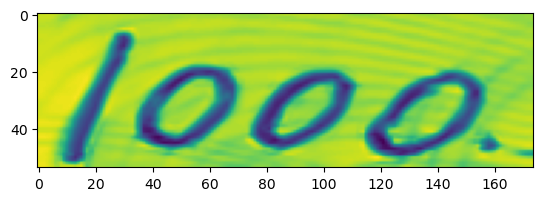

In [38]:
plot_random_image(all_labels,'/kaggle/working/inverted/')

# Shuffling Data (Necessery)

## based on these two plots its better to resize images to 53*173

In [39]:
digits= '0123456789'
img_h=54
img_w=174
#image Channels
img_c=1

# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(digits) +1
batch_size=64
max_length=8 # considering max length of ground truths labels to be 8

In [40]:
def encode_numbers_labels(number):
    label_lst=[]
    for char in str(number):
        label_lst.append(digits.find(char)) # keeping 0 for blank and for padding labels
    return label_lst

In [41]:
def numbers_from_labels(labels):
    txt=[]
    for ele in labels:
        if ele == len(digits): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(digits[ele])
    return "".join(txt)

In [42]:
def ctc_loss_function(args):
    y_pred, y_true, input_length, label_length = args
    y_pred = y_pred[:, 2:, :] # maybe need change based on my project and model architecture
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [43]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add, concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf

In [44]:
def Image_digit_recogniser_model_1(stage,drop_out_rate=0.35):
    img_h=54
    img_w=174
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        #input shape is (174, 54, 1)
        #input shape is (174, 54, 64)
        #input shape is (87, 27, 64)
        #input shape is (87, 27, 128)
        #input shape is (43, 13, 128)
        #input shape is (43, 13, 256)
        #input shape is (43, 6, 512)
        #input shape is (43, 3, 512)
        #input shape is (43, 1536)
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model)

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 3), name='max3')(model)

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model)

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    # CNN to RNN
    model = Reshape(target_shape=(43, 1024), name='reshape')(model)

    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model)
    y_pred = Activation('softmax', name='softmax')(model)


    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage=='train':
        return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[model_input], outputs=y_pred)



In [45]:
from keras import optimizers
adam=optimizers.Adam()

In [46]:
model_input,y_pred,img_digit_recog=Image_digit_recogniser_model_1('train')
test_func = K.function([model_input], [y_pred])
img_digit_recog.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)
img_digit_recog.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 174, 54, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 174, 54, 64)  640         ['img_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 174, 54, 64)  256        ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                              

# defining data generators

In [47]:
class DataGenerator(keras.callbacks.Callback):
    def __init__(self, df, img_w, img_h, batch_size, max_number_len=8):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_number_len = max_number_len

        self.df = df
        self.n = len(df)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.numbers = df['label'].tolist()  # Extract related labels from DataFrame


    def build_data(self):
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.df['/kaggle/working/inverted/']):
            img = cv2.imread(img_file)
            img = img[:,:,1]                               #Extracting Single Channel Image
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img /255
            self.imgs[i, :, :]= img
            if i%5000==0:
                print("Loaded Images: ",i)

        print("Number of Texts matches with Total Number of Images :",len(self.numbers) == self.n)
        print(self.n, " Image Loading finish...")

    def next_data(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.numbers[self.indexes[self.cur_index]]

    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_number_len])* -1
            input_length = np.ones((self.batch_size, 1)) * 40
            label_length = np.zeros((self.batch_size, 1))                   #label length for CTC
            source_str=[]                                                   #List to store Ground Truth Labels
            for i in range(self.batch_size):
                img, text = self.next_data() #getting the image and text data pointed by current index
                                    #taking transpose of image
                img=img.T
                img = np.expand_dims(img, -1)  #expanding image to have a single channel
                X_data[i] = img
                label=encode_numbers_labels(text) # encoding label text to integer list and storing in temp label variable
                lbl_len=len(label)
                Y_data[i,0:lbl_len] = label #Storing the label till its length and padding others
                label_length[i] = len(label)
                source_str.append(text) #storing Ground Truth Labels which will be accessed as reference for calculating metrics

        #Preparing the input for the Model
            inputs = {
                'img_input': X_data,
                'ground_truth_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                'source_str': source_str  # used for visualization only
            }
            #Preparing output for the Model and intializing to zeros
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs) # Return the Prepared input and output to the Model

In [48]:
test_set_precentage = int(len(all_labels) * 0.8)
val_set_precentage = int(len(all_labels) * 0.7 // 1)

In [49]:
test_set_precentage,val_set_precentage

(22008, 19257)

In [50]:
train_gene = DataGenerator(all_labels[:val_set_precentage], img_w, img_h, batch_size, max_number_len=8)
train_gene.build_data()
train_num_batches=int(train_gene.n / batch_size)

19257  Image Loading start...
Loaded Images:  0
Loaded Images:  5000
Loaded Images:  10000
Loaded Images:  15000
Number of Texts matches with Total Number of Images : True
19257  Image Loading finish...


In [51]:
val_gen=DataGenerator(all_labels[val_set_precentage:test_set_precentage], img_w, img_h, batch_size, max_number_len=8)
val_gen.build_data()
val_num_batches=int(val_gen.n / batch_size)

2751  Image Loading start...
Loaded Images:  0
Number of Texts matches with Total Number of Images : True
2751  Image Loading finish...


In [52]:
def decode_batch(test_func, number_batch):
    out = test_func([number_batch])[0] #returns the predicted output matrix of the model
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = numbers_from_labels(out_best)
        ret.append(outstr)
    return ret

In [53]:
def accuracies(actual_labels,predicted_labels,is_train):
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    for i in range(len(actual_labels)):
        predicted_output=predicted_labels[i]
        actual_output=actual_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
    final_accuracy=np.round((accuracy/len(actual_labels))*100,2)
    final_letter_acc=np.round((letter_acc/letter_cnt)*100,2)
    return final_accuracy,final_letter_acc

## callback visualizer

In [54]:
class VizCallback(keras.callbacks.Callback):
    """
    The Custom Callback created for printing the Accuracy and Letter Accuracy Metrics at the End of Each Epoch
    """

    def __init__(self, test_func, text_img_gen,is_train,acc_compute_batches):
        self.test_func = test_func
        self.text_img_gen = text_img_gen
        self.is_train=is_train                #used to indicate whether the callback is called to for Train or Validation Data
        self.acc_batches=acc_compute_batches  # Number of Batches for which the metrics are computed typically equal to steps/epoch

    def show_accuracy_metrics(self,num_batches):
        """
        Calculates the accuracy and letter accuracy for each batch of inputs,
        and prints the avarage accuracy and letter accuracy across all the batches
        """
        accuracy=0
        letter_accuracy=0
        batches_cnt=num_batches
        while batches_cnt>0:
            number_batch = next(self.text_img_gen)[0]   #Gets the next batch from the Data generator
            decoded_res = decode_batch(self.test_func,number_batch['img_input'])
            actual_res=number_batch['source_str']
            acc,let_acc=accuracies(actual_res,decoded_res,self.is_train)
            accuracy+=acc
            letter_accuracy+=let_acc
            batches_cnt-=1
        accuracy=accuracy/num_batches
        letter_accuracy=letter_accuracy/num_batches
        if self.is_train:
            print("\nTrain Average Accuracy of "+str(num_batches)+" Batches: ",np.round(accuracy,2)," %")
            print("Train Average Letter Accuracy of "+str(num_batches)+" Batches: ",np.round(letter_accuracy,2)," %")
        else:
            print("Validation Average Accuracy of "+str(num_batches)+" Batches: ",np.round(accuracy,2)," %")
            print("Validation Average Letter Accuracy of "+str(num_batches)+" Batches: ",np.round(letter_accuracy,2)," %")


    def on_epoch_end(self, epoch, logs={}):
        self.show_accuracy_metrics(self.acc_batches)

In [55]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop=EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
model_chk_pt=ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=False,save_weights_only=True,verbose=0, mode='auto', period=2)
logdir = os.path.join("logs_127", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [56]:
%load_ext tensorboard
%tensorboard --logdir logs_127
clear_output()

In [57]:
viz_cb_train = VizCallback( test_func, train_gene.next_batch(),True,train_num_batches)
viz_cb_val = VizCallback( test_func, val_gen.next_batch(),False,val_num_batches)

In [58]:
history = img_digit_recog.fit(
    train_gene.next_batch(),
    steps_per_epoch=int(train_gene.n / batch_size),
    epochs=30,
    callbacks=[viz_cb_train, viz_cb_val, train_gene, val_gen, tensorboard_callback, early_stop, model_chk_pt],
    validation_data=val_gen.next_batch(),
    validation_steps=int(val_gen.n / batch_size)
)
img_digit_recog.save("forth_model.h5")
print("model saved")


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['source_str'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-08-13 12:42:31.603821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - ETA: 0s - loss: 9.2942
Train Average Accuracy of 300 Batches:  3.0  %
Train Average Letter Accuracy of 300 Batches:  23.64  %
Validation Average Accuracy of 42 Batches:  3.76  %
Validation Average Letter Accuracy of 42 Batches:  23.8  %
300/300 [==============================] - 106s 287ms/step - loss: 9.2942 - val_loss: 11.3588
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 2.2783
Train Average Accuracy of 300 Batches:  61.66  %
Train Average Letter Accuracy of 300 Batches:  82.57  %
Validation Average Accuracy of 42 Batches:  47.25  %
Validation Average Letter Accuracy of 42 Batches:  70.74  %
300/300 [==============================] - 85s 285ms/step - loss: 2.2783 - val_loss: 3.9062
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 1.2900
Train Average Accuracy of 300 Batches:  74.75  %
Train Average Letter Accuracy of 300 Batches:  88.38  %
Validation Average Accuracy of 42 Batches:  61.94  %
Vali

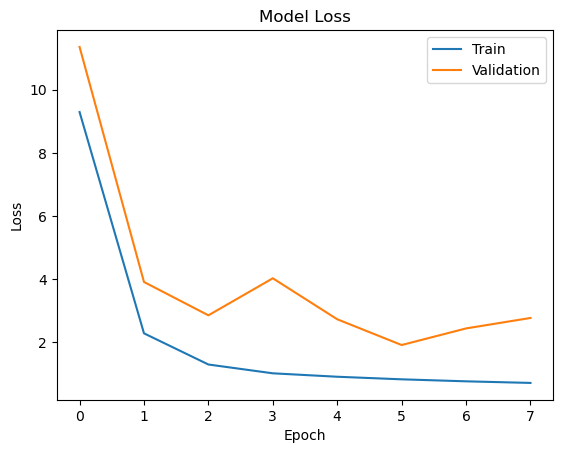

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



## now measure our model on test dataset

actually we dont have dataset

so we can use new data or train out model on smaller dataset

In [60]:
def decode_label(out):
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=numbers_from_labels(out_best)
    return outstr

test on an image created by myself

In [ ]:
# Dont forget PATH for model
img_digit_recog.save("forth_model.h5")

In [61]:
model=Image_digit_recogniser_model_1('predict')
# model = keras.models.load_model('first_model.h5',compile=False)
model.load_weights('forth_model.h5')

In [62]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 174, 54, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 174, 54, 64)       640       
                                                                 
 batch_normalization_7 (Batc  (None, 174, 54, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 174, 54, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 87, 27, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 87, 27, 128)       73856     
                                                           

In [64]:
test_data = all_labels[test_set_precentage:]
val_img_names=test_data['/kaggle/working/inverted/'].values
val_labels=test_data['label'].values

In [195]:
def test_data_output_Prediction(model, test_img_names, test_labels):
    num_classes = 10  # Assuming there are 10 digits (0 to 9)
    accuracy = 0
    letter_acc = [0] * num_classes
    letter_total = [0] * num_classes
    count = 0
    all_predicted = []
    letter_mis_match = []

    for i in range(len(test_labels)):
        test_img = cv2.imread(test_img_names[i])
        test_img_resized = cv2.resize(test_img, (174, 54))
        test_image = test_img_resized[:, :, 1]
        test_image = test_image.T
        test_image = np.expand_dims(test_image, axis=-1)
        test_image = np.expand_dims(test_image, axis=0)
        test_image = test_image / 255
        model_output = model.predict(test_image, verbose=-1)
        predicted_output = decode_label(model_output)
        actual_output = test_labels[i]
        all_predicted.append([test_img_names[i], predicted_output])
        count += 1
        mis_match = 0

        for j in range(min(len(predicted_output), len(actual_output))):
            if predicted_output[j] == actual_output[j]:
                letter_acc[int(predicted_output[j])] += 1
            else:
                mis_match += 1
            letter_total[int(actual_output[j])] += 1

        letter_mis_match.append(mis_match)
        if actual_output == predicted_output:
            accuracy += 1

        if (count % 200) == 0:
            print("Processed", count, "Images")

    digit_accuracy = [acc / total if total > 0 else 0 for acc, total in zip(letter_acc, letter_total)]
    return accuracy, letter_acc, letter_total, digit_accuracy, letter_mis_match, all_predicted


In [ ]:
synth_val_accuracy,letter_acc,synth_val_letter_acc,synth_val_letter_cnt,synth_val_mis_match,all_predicted=test_data_output_Prediction(model,val_img_names,val_labels)
synth_val_accuracy,letter_acc,synth_val_letter_acc,synth_val_letter_cnt,synth_val_mis_match


In [ ]:
true_list = []
for i in range(len(all_labels['label'].iloc[test_set_precentage:])):
  if str(all_labels['label'].iloc[test_set_precentage + i]) == str(all_predicted[i][1]):
    true_list.append(1)
  else:
    print(all_labels['label'].astype(str).iloc[test_set_precentage + i]," == ",all_predicted[i][1],"image -->",all_predicted[i][0])
    true_list.append(0)
trues = pd.DataFrame(true_list)
trues[0].describe()

As can be seen, due to the large number of zeros in the training dataset, most of the prediction errors have been replaced by zeros

/tmp/ipykernel_28/2995881611.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pre_digits_df.append({0:0},ignore_index=True)
/tmp/ipykernel_28/2995881611.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  digits_df.append({0:0},ignore_index=True)


27246


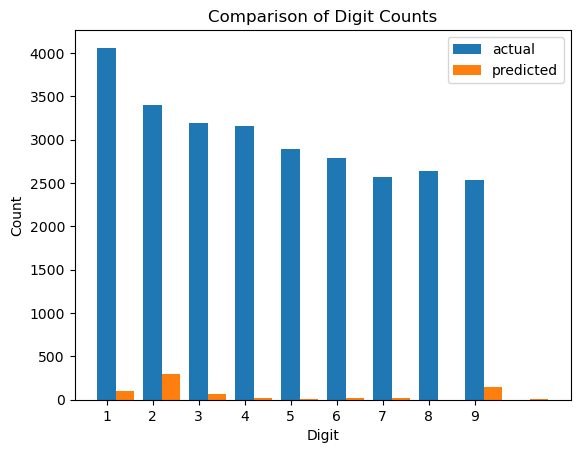

In [200]:
pre_digits_df = pd.DataFrame(letter_acc)
pre_digits_df.append({0:0},ignore_index=True)


all_digits = []
for i in all_labels['label'].iloc[test_set_precentage:]:
  for ii in i:
    all_digits.append(ii)
print(len(all_digits))
digits_df = pd.DataFrame(all_digits)
digits_df.append({0:0},ignore_index=True)
digit_counts = digits_df[0]

digit_counts = pd.DataFrame(digit_counts)
digit_counts = digit_counts[0].value_counts()
digit_counts = pd.DataFrame(digit_counts)


df1 = digit_counts.sort_index()
df2 = pre_digits_df.sort_index()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data for the first dataframe
ax.bar(df1.index, df1[0], width=0.4, align='center', label='actual')

# Plot the data for the second dataframe (shifted by 0.4 for side-by-side comparison)
ax.bar(df2.index + 0.4, df2[0], width=0.4, align='center', label='predicted')

# Set labels and title
ax.set_xlabel('Digit')
ax.set_ylabel('Count')
ax.set_title('Comparison of Digit Counts')
ax.set_xticks(df1.index)
ax.legend()

# Show the plot
plt.show()


## Exploring all digits count in our main dataset

In [105]:
all_digits = []
for i in all_labels['label']:
  for ii in i:
    all_digits.append(ii)
print(len(all_digits))
digits_df = pd.DataFrame(all_digits)

135187


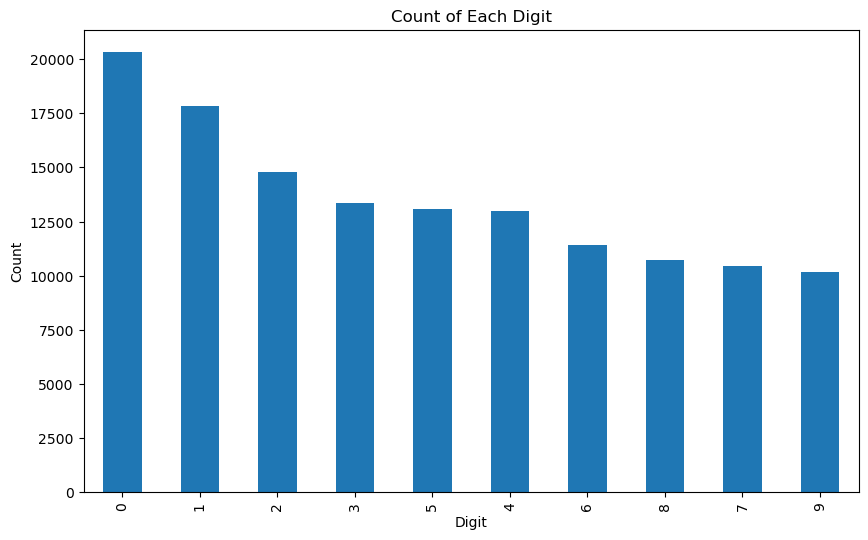

In [106]:
import matplotlib.pyplot as plt

# Calculate the frequency of each digit
digit_counts = digits_df[0].value_counts()

# Plot the count of each digit
plt.figure(figsize=(10, 6))
digit_counts.plot(kind='bar')
plt.title('Count of Each Digit')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()


## testing one specific image

In [ ]:
# test_img=cv2.imread(all_labels['./inverted/'].iloc[0])
# test_img_resized=cv2.resize(test_img,(174,54))
# test_image=test_img_resized[:,:,1]
# test_image=test_image.T
# test_image=np.expand_dims(test_image,axis=-1)
# test_image=np.expand_dims(test_image, axis=0)
# test_image=test_image/255
# model_output=model.predict(test_image , verbose=-1)
# predicted_output=decode_label(model_output)
# predicted_output

In [144]:
def predictor(model,image_path):
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    #denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)
    resized_img = cv2.resize(gray_img,(174,54))
    _, binary_im = cv2.threshold(resized_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #inverted_img = cv2.bitwise_not(binary_im)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_img = cv2.dilate(inverted_img, kernel, iterations=1)
    # dilated_img = cv2.dilate(dilated_img, kernel, iterations=1)
    test_image=binary_im.T
    test_image=np.expand_dims(test_image,axis=-1)
    test_image=np.expand_dims(test_image, axis=0)
    for_show = test_image
    plt.imshow(for_show.reshape(174,54,1), cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off axis labels
    plt.show()
    test_image=test_image/255
    model_output=model.predict(test_image , verbose=-1)
    predicted_output=decode_label(model_output)
    return predicted_output


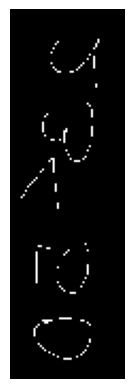

'8888'

In [145]:
prediction = predictor(model,'/kaggle/input/test-image/test.png')
prediction

## load DIDA into dataframe

In [191]:
dida_images_dir_path = '/kaggle/input/DIDA-for-test/DIDA_1/'
import pandas as pd
dida_labels_dir_path = '/kaggle/input/dida-labels/DIDA_12000_String_Digit_Labels.csv'
your_header = ['image_name', 'label']
dida_labels = pd.read_csv(dida_labels_dir_path)
dida_labels.columns = your_header


dida_labels['image_name'] = dida_labels['image_name'].astype(str)
dida_labels['label'] = dida_labels['label'].astype(str)
dida_paths = []
for row in dida_labels['image_name'].astype(str) :
    full_path = dida_images_dir_path + row + '.jpg'
    dida_paths.append(full_path)
dida_labels['image_path'] = dida_paths
dida_labels.drop(columns=['image_name'], inplace=True)
dida_labels

dida_sample = dida_labels.sample(n=500, random_state=42)
dida_sample

,label,image_path
1935,1831,/kaggle/input/DIDA-for-test/DIDA_1/1937.jpg
6494,1801,/kaggle/input/DIDA-for-test/DIDA_1/6496.jpg
1720,1814,/kaggle/input/DIDA-for-test/DIDA_1/1722.jpg
9120,1808,/kaggle/input/DIDA-for-test/DIDA_1/9122.jpg
360,1806,/kaggle/input/DIDA-for-test/DIDA_1/362.jpg
...,...,...
6455,1837,/kaggle/input/DIDA-for-test/DIDA_1/6457.jpg
14,1213,/kaggle/input/DIDA-for-test/DIDA_1/16.jpg
2802,1832,/kaggle/input/DIDA-for-test/DIDA_1/2804.jpg
11513,1824,/kaggle/input/DIDA-for-test/DIDA_1/11515.jpg


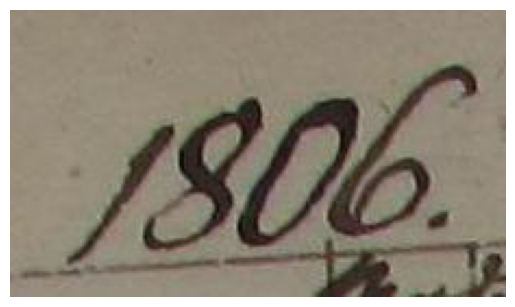

In [198]:
image = cv2.imread(dida_images_dir_path + '362.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

In [193]:
test_data = dida_sample
dida_img_names=test_data['image_path'].values
dida_labels=test_data['label'].values

In [ ]:
synth_val_accuracy,letter_acc,synth_val_letter_acc,synth_val_letter_cnt,synth_val_mis_match,all_predicted=test_data_output_Prediction(model,dida_img_names,dida_labels)
synth_val_accuracy,letter_acc,synth_val_letter_acc,synth_val_letter_cnt,synth_val_mis_match


In [197]:
true_list = []
for i in range(len(dida_sample)):
  if str(dida_sample['label'].iloc[i]) == str(all_predicted[i][1]):
    true_list.append(1)
    print(dida_sample['label'].astype(str).iloc[i]," == ",all_predicted[i][1],"image -->",all_predicted[i][0])
  else:
    true_list.append(0)
trues = pd.DataFrame(true_list)
trues[0].describe()

1806  ==  1806 image --> /kaggle/input/DIDA-for-test/DIDA_1/362.jpg
1818  ==  1818 image --> /kaggle/input/DIDA-for-test/DIDA_1/2223.jpg
1805  ==  1805 image --> /kaggle/input/DIDA-for-test/DIDA_1/9711.jpg
1802  ==  1802 image --> /kaggle/input/DIDA-for-test/DIDA_1/6120.jpg
1824  ==  1824 image --> /kaggle/input/DIDA-for-test/DIDA_1/11506.jpg
1825  ==  1825 image --> /kaggle/input/DIDA-for-test/DIDA_1/11075.jpg
1829  ==  1829 image --> /kaggle/input/DIDA-for-test/DIDA_1/10997.jpg
1826  ==  1826 image --> /kaggle/input/DIDA-for-test/DIDA_1/5001.jpg
1805  ==  1805 image --> /kaggle/input/DIDA-for-test/DIDA_1/8482.jpg
1832  ==  1832 image --> /kaggle/input/DIDA-for-test/DIDA_1/9269.jpg
1810  ==  1810 image --> /kaggle/input/DIDA-for-test/DIDA_1/10430.jpg
1832  ==  1832 image --> /kaggle/input/DIDA-for-test/DIDA_1/7617.jpg
1825  ==  1825 image --> /kaggle/input/DIDA-for-test/DIDA_1/2089.jpg
1812  ==  1812 image --> /kaggle/input/DIDA-for-test/DIDA_1/10875.jpg
1823  ==  1823 image --> /kagg

count    500.000000
mean       0.112000
std        0.315682
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: 0, dtype: float64